In [1]:
import os, copy, time, sys, random
import pandas as pd, numpy as np
from datetime import datetime
import json
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np
from gym.utils import seeding

from glob import glob
# Custom Imports:
from utils.pipelines import preprocess_df, preprocess_price
from utils.split import time_split
from utils.eval import eval_policy, evaluate
from envs.discrete_stock_env import DiscreteStockEnvironment
from envs.continious_stock_env import ContiniousStockEnvironment
from utils.device import get_device
from agents.sb_agents import SBAgent
from engine.train_sbagent import train_A2C, train_ACER, train_DDPG, train_PPO
from utils.json import json_print
from preprocessing.correlation import drop_correlated_features
device = get_device()

print(f'{device} is used as accelerator')

cpu is used as accelerator


/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
#!pip install python-binance
from binance.client import Client


apiKey = ""
secretKey = ""

client = Client(apiKey, secretKey)

# For Binance
binance_symbols = [
                    "BTCUSDT",
                    "ETHBTC", 
                    "XRPBTC"
]

def fetch_binance_data(coin_list:list = ["BTCUSDT"], time_interval:str = Client.KLINE_INTERVAL_15MINUTE, remove_past_csv:bool = True):
    
    """ Fetching and saving OCHLV from Binance API with given coin names and time interval. 
    
        Args:
            - coin_list (list):     List of Coin Symbols (Default BTCUSDT)
            - time_interval (str):  Time Interval (Default 15m)
            - remove_past_csv (bool):   If True, remove all .csv files in data path for memory efficiency
            
        Returns:
            - cryto_paths (dict):  Dict of data frame paths, where keys are crypto names and values are .csv paths.
    """
    
    if not isinstance(coin_list, list):
        coin_list = [coin_list]
        
    cryto_paths = {}
    

    if remove_past_csv:
        for past_data in glob('./data/*.csv'):
            os.remove(past_data)
            print(f"{past_data} file is found and deleted.")
            
            
    for crypto_symbol in coin_list:
        
        print(f"{crypto_symbol} is fetching from Binance API.")
        
        klines = client.get_historical_klines(crypto_symbol, time_interval , "1 Jan, 2016")
        df_klines = pd.DataFrame(klines, columns = ['Date', 'Open', 'High', 'Low', 'Close',
                                                    'Volume', 'closeTime', 'quoteAssetVolume',
                                                    'NumTrade', 'takerBuyBaseVol', 'takerBuyQuoteVol',
                                                    'ignore']
        )

        df_klines['Date'] = pd.to_datetime(df_klines['Date'], unit='ms')
        df_klines = df_klines[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
        

        start_date = str(df_klines['Date'].iloc[0])[:16]
        end_date = str(df_klines['Date'].iloc[-1])[:16]
        save_path = f"{crypto_symbol}-{time_interval}-{start_date}-{end_date}.csv"
        save_path = os.path.join(f'./data/{save_path}')  
        df_klines.to_csv(save_path, index = False) 

        cryto_paths[crypto_symbol] = save_path

        return cryto_paths


In [3]:
cryto_paths = fetch_binance_data(coin_list = "BTCUSDT", time_interval = Client.KLINE_INTERVAL_15MINUTE)

./data/DOGEUSDT-15m-2019-07-05 12:00-2021-07-09 15:15.csv file is found and deleted.
./data/DOGEUSDT-15m-2019-07-05 12:00-2021-07-09 15:15.csv_with_indicators_pMReeelsss.csv file is found and deleted.
BTCUSDT is fetching from Binance API.


In [49]:
algorithms_features = {'PPO' : ['Box', 'Discrete', 'MultiDiscrete', 'MultiProcessing'],
                       'A2C' : ['Box', 'Discrete', 'MultiDiscrete', 'MultiProcessing'],
                       'DDPG': ['Box', '-', '-',  '-'],
                       'DQN' : ['_', 'Discrete', '-',  '-'],
                       'SAC' : ['Box', '-', '-',  '-'],
                       'TD3' : ['Box', '-', '-',  '-']                     
}
algorithms_features = pd.DataFrame(algorithms_features).T
algorithms_features

0         1              2                3
PPO   Box  Discrete  MultiDiscrete  MultiProcessing
A2C   Box  Discrete  MultiDiscrete  MultiProcessing
DDPG  Box         -              -                -
DQN     _  Discrete              -                -
SAC   Box         -              -                -
TD3   Box         -              -                -

In [50]:
import os, copy, time, sys, random
import pandas as pd, numpy as np
from collections import deque
from datetime import datetime
import pickle
import warnings



# Normalization of observations:
from sklearn import preprocessing

import gym
from gym import spaces
import numpy as np

from utils.pipelines import preprocess_df, preprocess_price
from utils.split import time_split
# Custom Imports:
from render.graph import TradingGraph
from envs.to_gym import DiscreteGymEnvironment, ContiniousGymEnvironment
from utils.eval import eval_policy, evaluate
import preprocessing.transforms as T


import gym
from gym import spaces

class DiscreteGymEnvironment(gym.Env):

    def __init__(self, ohclv_size:int = 5, lookback_window_size:int = 300, num_extra_feature:int = 9):

        super(DiscreteGymEnvironment, self).__init__()

        # Actions of the format Buy 1/10, Sell 3/10, Hold, etc.
        # Action space is represented as discrete set of 3 options
        # i.e., buy, sell and hold. And, another discrete set of 10
        # amounts (1/10,...,10/10). When the buy is selected, we will buy
        # amount * self.balance worth of crypto. For the sell action, we will sell
        # amount * self.btc_held worth of BTC. Hold action ignores the amount and do
        # nothing
        # Actions of the format Buy 1/10, Sell 3/10, Hold (amount ignored), etc.
        self.action_space = spaces.MultiDiscrete([3, 100])

        # Prices contains the OHCLV (Open,High,Close,Low,Volume) values, net worth and trade history
        # Observes the OHCLV values, net worth, and trade history
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape = (lookback_window_size, ohclv_size + 5 + num_extra_feature), dtype=np.float16)
        
        
    def action_decompose(self, action):
        """ Returns decomposed action, action type and amount """
        action_type = action[0]
        amount = action[1] / 100
        return action_type, amount

class DiscreteStockEnvironment(DiscreteGymEnvironment):

    """A Quantitative Finance trading environment for OpenAI gym """
    metadata = {'render.modes': ['human', 'system', 'none']}
    standardizer = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    
    actions = {0: 'Hold',
               1: 'Buy',
               2: 'Sell'}
    
    viewer = None

    def __init__(self, df:pd.DataFrame, lookback_window_size:int = 50, initial_balance:float = 10000,
                 indicator_list:list = ['sma7', 'sma25','sma99','bb_bbm','bb_bbh', 'bb_bbl', 'psar', 'MACD', 'RSI'],
                 ohlcv_list:list = ['Open','High','Low','Close', 'Volume'],
                 commission:float = 0.00075, reward_strategy:str = 'PnL', sequential:bool=False, adjust_price:bool = True,
                 render_range:int = 100, show_reward:bool=False, show_indicators:bool=False, debug:bool = False,
                 slippage:float = 0.01, transform_obs:str = 'None', visualize:bool = False, dropna:bool = True,
                 normalize_obs:bool=True, name:str ="Custom Trading Environment", seed:int = None, info:str = "Describe Me!"):
        
        super(DiscreteStockEnvironment, self).__init__( len(ohlcv_list), lookback_window_size, len(indicator_list))
        
        self._indicator_cols = ['sma7','sma25','sma99','bb_bbm','bb_bbh',
                                'bb_bbl','psar','MACD','RSI','ema7','ema25',
                                'ema99', 'super_trend', 'super_trend_s',
                                'super_trend_l', 'log_return']
        
        self._reward_strategies = ['base','incremental', 'benchmark', 'sharp_ratio', 'PnL']
        
        self._transform_names = ['None', 'minmax', 'mean_norm', 'diff', 'log_diff']
        
        self._ohlcv_cols = ['Open','High','Low','Close', 'Volume']
        
        
        assert reward_strategy in self._reward_strategies, f'Unknown reward stratedy {reward_strategy}'
        assert transform_obs in self._transform_names, f'Unknown transformation for observation space {transform_obs}'
        assert all(indicator in  self._indicator_cols for indicator in indicator_list), 'Unknown indicator!'
        assert all(value in  self._ohlcv_cols for value in ohlcv_list), 'Unknown indicator!'
        
        if not isinstance(df, (pd.DataFrame)):
            warnings.warn(f'df object must be a pd.DataFrame, got {type(df)}') 
            
        if seed is not None:
            self._seed_manuel(seed)
            self.seed(seed)
        
        # Name of the environment:
        self.name = name

        self.df = df.dropna().reset_index() if dropna else df.fillna(method = 'backfill').reset_index()
        self.df_total_steps = len(self.df) - 1
        
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.reward_strategy = reward_strategy
        
        self.indicator_list = indicator_list
        self.ohlcv_list = ohlcv_list
        
        self._features = {'features': ohlcv_list + indicator_list}
        
        
        # İf true => retuns the dimensions of the parameters in dict:
        self.debug = debug  
        self.shapes = {'df': self.df.shape} if self.debug else None

        self.commission = commission
        self.slippage = slippage       
        self.sequential = sequential
        self.normalize_obs = normalize_obs
        self.transform_obs = transform_obs
        
        
        self.transforms = [T.identity, T.max_min_normalize, T.mean_normalize, T.difference, T.log_and_difference]
        # See transformations:
        self.transform_dict = {name:transform for name, transform in zip(self._transform_names, self.transforms)}

        self.visualize = visualize
        self.render_range = render_range 
        self.show_reward = show_reward 
        self.show_indicators = show_indicators
        
        self.trade_minutes_in_year = 365*24*60
        self.excess_daily_return_ratio = 0.05 
        
        self.adjust_price = adjust_price
        
        self._config = {'normalize_obs'     :  normalize_obs, 
                        'transform_obs'     :  transform_obs,
                        'commission'        :  commission,
                        'name'              :  name,
                        'info'              :  info,
                        'seed'              :  seed,
                        }

        self._start_trade_session()    
        
    def _start_trade_session(self):
        """ Initalizes the order, market and indicator history with fixed sizes """
        self.orders_history = deque(maxlen=self.lookback_window_size)
        self.market_history = deque(maxlen=self.lookback_window_size)
        self.indicators_history = deque(maxlen=self.lookback_window_size)
        
    def adjust_slippage(self, threshold:float = np.random.uniform(0.9, 1)):
        """ Slippage Modifier """
        chance = np.random.uniform(0, 1)

        if chance > threshold:
            self.slippage = np.random.uniform(0.0001, 0.005)
        else:
            self.slippage = np.random.uniform(0.00001, 0.0001)

    def get_order_history(self):
        """  Returns portolio of current state """
        return [self.balance, 
                self.net_worth,
                self.crypto_bought,
                self.crypto_sold,
                self.crypto_held]
    
    def apply_transform_obs(self, state):
        """  Applies the transformation to the observations """
        return self.transform_dict[self.transform_obs](state)
    
    def get_market_history(self, current_step):
        """ Returns  OHLCV """
        market_history = [self.df.loc[current_step, col] for col in self.ohlcv_list]
        return  market_history 
    
    def get_open_close(self):
        """ Returns Open and Close values in dict"""
        return {'Open' : self.df.loc[self.current_step, 'Open'],
                'Close': self.df.loc[self.current_step, 'Close']}
    
    def get_indicator_history(self, current_step):
        """ Returns list of indicators in the current step """
        indicators = [self.df.loc[current_step, indicator] for indicator in self.indicator_list]
        return indicators
    
    def _reset_session(self):
        """ Starts a new session """
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.crypto_held = 0
        self.crypto_sold = 0
        self.crypto_bought = 0
        self.episode_orders = 0 
        self.prev_episode_orders = 0
        self.punish_value = 0
        self.rewards = deque(maxlen=self.render_range)
        self.trades = deque(maxlen=self.render_range)
        
    def reset(self, n_iter = 500):
        """ Resets the environment and returns new observation """
        
        if self.sequential and self.visualize:
            self.visualization = TradingGraph(render_range = self.render_range, show_reward = self.show_reward, show_indicators = self.show_indicators) 
        
        self._reset_session()
        self.env_steps_size = n_iter
       

        # Random traversing => More unique data points:
        if not self.sequential:
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - n_iter)
            self.end_step = self.start_step + n_iter
            
        # Sequential traversing:
        else: 
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step
        
        # Refreshing memories => Filling last lookback_window_size # of observations:
        self._fill_history()
        
        debug = self.add_feature_shape() if self.debug else None

        state = np.concatenate([self.market_history, self.orders_history, self.indicators_history], axis=1)    
        state = self.apply_transform_obs(state) if self.transform_obs is not None else state 
        state = self.scaler.fit_transform(state) if self.normalize_obs else state

        return state
    
    def _fill_history(self):
        """ Refreshing memories => Filling last lookback_window_size # of observations """
        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append(self.get_order_history())
            self.market_history.append(self.get_market_history(current_step))
            self.indicators_history.append(self.get_indicator_history(current_step))
        
    
    def add_feature_shape(self):
        """ Adds market, order and indicator history shape to shape dict for debugging """
        self.shapes['market_history'] = np.shape(self.market_history)
        self.shapes['orders_history'] = np.shape(self.orders_history)
        self.shapes['indicators_history'] = np.shape(self.indicators_history)
    
    def _next_observation(self):
        """ Get new the data points """
        self.market_history.append(self.get_market_history(self.current_step))
        self.indicators_history.append(self.get_indicator_history(self.current_step))

        obs = np.concatenate([self.market_history, self.orders_history, self.indicators_history], axis=1) 

        if self.transform_obs is not None:
            obs = self.apply_transform_obs(obs)
            
        if self.normalize_obs:
            obs = self.scaler.fit_transform(obs)

        return obs

    def _get_current_price(self):
        """ Returns current Open price """
        return self.df.loc[self.current_step, 'Open'] + (np.random.rand())
    
    def _get_random_current_price(self):
        """ Returns current price from Open and Close values randomly """
        return random.uniform(
            self.df.loc[self.current_step, 'Open'],
            self.df.loc[self.current_step, 'Close']
        ) + np.random.rand()

    def get_dcl(self):
        """ Returns dict of DCL """
        return {'Date'  : self.df.loc[self.current_step, 'Date'],
                'High'  : self.df.loc[self.current_step, 'High'],
                'Low'   : self.df.loc[self.current_step, 'Low']}
    
    def step(self, action):
        """ Performs one step (BUY, SELL, HOLD) with given action """
        self.crypto_bought = 0
        self.crypto_sold = 0
        self.current_step += 1
         
        action_type, amount = super(DiscreteStockEnvironment, self).action_decompose(action) #self.action_decompose(action)

        assert action_type in [0, 1, 2], f'Unknown action type found : {action_type}, should be in [0, 1, 2]'
        assert 0.0 <= amount <= 1.0, f'Unknown amount type found : {amount}, should be in [0, 0.1, 0.2, ... , 1]'

        current_price = self._get_random_current_price()
 
        self.adjust_slippage()
        

        if self.actions[action_type] == 'Hold':
            
            adjust_price = 1.0
            self.trades.append({**self.get_dcl(),
                    'total' : 0,
                    'type'  : "hold",
                    'current_price': current_price,
                    'adj_price': adjust_price})

        
        elif self.actions[action_type] == 'Buy' and self.balance > self.initial_balance * 1e-3:
            
            self.crypto_bought = self.balance / current_price * amount
            adjust_price = (1 + self.commission) * (1 + self.slippage) if self.adjust_price else 1.0
            
            if self.crypto_bought * current_price < 10:
                self.trades.append({**self.get_dcl(),
                    'total' : 0,
                    'type'  : "holdBuy",
                    'current_price': current_price,
                    'adj_price': adjust_price})
            else:
                self.balance -= (self.crypto_bought * current_price) * adjust_price
                self.crypto_held += self.crypto_bought

                self.trades.append({**self.get_dcl(),
                                    'total' : self.crypto_bought,
                                    'type'  : "buy",
                                    'current_price': current_price,
                                    'adj_price': adjust_price})

                self.episode_orders += 1
        
  
        elif self.actions[action_type] == 'Sell' and self.crypto_held > 0:
    
            self.crypto_sold = self.crypto_held * amount
            adjust_price = (1 - self.commission) * (1 - self.slippage) if self.adjust_price else 1.0
            
            if self.crypto_sold * current_price < 10:
                                
                self.trades.append({**self.get_dcl(),
                    'total' : 0,
                    'type'  : "holdSell",
                    'current_price': current_price,
                    'adj_price': adjust_price})
            else:
                self.balance += (self.crypto_sold * current_price)  * adjust_price
                self.crypto_held -= self.crypto_sold

                self.trades.append({**self.get_dcl(),
                                    'total' : self.crypto_sold,
                                    'type'  :  "sell",
                                    'current_price': current_price,
                                    'adj_price': adjust_price})
                self.episode_orders += 1

        self.net_worth = self.balance + self.crypto_held * current_price
        self.orders_history.append(self.get_order_history())
        
        reward = self.get_reward()
        done =  self.get_done()
        obs = self._next_observation()
        info = self.get_info() 
               
        
        self._update_net_worth()

        return obs, reward, done, info
    
    def _update_net_worth(self):
        """ Updates the previous net worth for rewarding actions and maximum net worth since episode"""
        self.prev_net_worth = self.net_worth
        
        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth
        
    
    def get_reward(self):
        """ Returns reward with initially given stragedy """
        
        if self.reward_strategy == 'incremental':
            reward = self.get_incremental_reward()
            
        elif self.reward_strategy == 'benchmark':
            reward = self.get_benchmark_reward()
            
        elif self.reward_strategy == 'sharp_ratio':
            reward = self.get_sharp_ratio_reward()
            
        elif self.reward_strategy == 'PnL':
            reward = self.get_PnL_reward()
            
        else:
            reward = self.get_base_reward()
            
        return reward
    
    def get_base_reward(self):
        """ Vanilla reward function, performs temporal difference between current and previous net worth"""
        return (self.net_worth - self.prev_net_worth) / self.prev_net_worth
    
    def get_PnL_reward(self):
        """ Returns PnL as percentage """
        return (self.net_worth - self.initial_balance) / self.initial_balance
    
    def get_done(self):
        """ Returns True if net worth is equal or smaller to %50 of initial balance or random traversing ends"""
        done = self.net_worth <= (self.initial_balance / 2) or self.current_step == self.end_step
        return done if isinstance(done, bool) else bool(done)
        
    
    def get_info(self):
        """ Returns a dict of last trade, orders, and shape of the matrices is debug True"""
        info =  {
                'trade'    :    self.trades[-1] if len(self.trades) > 0 else [],
                'order'    :    { 'balance'      : self.balance, 
                                  'net_worth'     : self.net_worth,
                                  'crypto_bought' : self.crypto_bought,
                                  'crypto_sold'   : self.crypto_sold,
                                  'crypto_held'   : self.crypto_held},
            
                'shapes'    :    self.shapes if self.debug else None,
                'Net Worth' :    self.net_worth,
                'Adj price' :    self.adjust_price
                }
        
        return self.render_excel()
    
    def render_excel(self):
        """ Returns a dict of last trade, orders, and shape of the matrices is debug True"""
        
            
        initial_trade = {'Date'  : self.df.loc[self.current_step, 'Date'],
                         'High'  : self.df.loc[self.current_step, 'High'],
                         'Low'   : self.df.loc[self.current_step, 'Low'],
                         'total' : 0.0,
                         'type'  :  "nothing",
                         'current_price': self._get_random_current_price()}

        trades = self.trades[-1] if len(self.trades) > 0 else initial_trade
        
        
        return {
                **trades,
                **self.get_open_close(),
                'balance'       : self.balance, 
                'net_worth'     : self.net_worth,
                'crypto_bought' : self.crypto_bought,
                'crypto_sold'   : self.crypto_sold,
                'crypto_held'   : self.crypto_held,
                'profit'        : self.net_worth - self.initial_balance,
                'profit_percent(%)': (self.net_worth - self.initial_balance) / self.initial_balance * 100,
                **self._features,
                'Initial Balance'  : self.initial_balance,
                'Lookback_size'    : self.lookback_window_size,
                'Reward strategy'  : self.reward_strategy,
                'current_step'     : self.current_step,
                'current_date'     : self.df.loc[self.current_step, 'Date'],
                **self._config,
                }
    
    
    def get_benchmark_reward(self):
        """ Returns reward as the squared distance between benchmark profit and current profit """
        profit_percent = (self.net_worth - self.initial_balance) / self.initial_balance * 100
        benchmark_profit = (self._get_current_price()  / self.df.loc[self.start_step, 'Open'] - 1) * 100
        diff = profit_percent - benchmark_profit
        reward = np.sign(diff) * (diff)**2
        return reward
       
    def get_incremental_reward(self):
        """ Returns a reward as a three way:
            1) Positive reward profits from holding asset while it is increasing
            2) Positive reward profits from not holding asset while it is decreasing 
            3) Negative reward for nothing (HOLD) for long time
        """
        self.punish_value += self.net_worth * 0.00001
        if self.episode_orders > 1 and self.episode_orders > self.prev_episode_orders:
            self.prev_episode_orders = self.episode_orders
            if self.trades[-1]['type'] == "buy" and self.trades[-2]['type'] == "sell":
                reward = self.trades[-2]['total']*self.trades[-2]['current_price'] - self.trades[-1]['total']*self.trades[-1]['current_price']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
            elif self.trades[-1]['type'] == "sell" and self.trades[-2]['type'] == "buy":
                reward = self.trades[-1]['total']*self.trades[-1]['current_price'] - self.trades[-2]['total']*self.trades[-2]['current_price']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
        else:
            return 0 - self.punish_value
        
    def get_sharp_ratio_reward(self):
        """ Returns sharp ratio as reward. The Sharpe ratio is a measure of risk-adjusted return. """
        # Use the percentage change method to easily calculate daily returns
        self.df['daily_ret'] = self.df['Close'].pct_change(1).fillna(method = 'backfill')

        # Assume an average minute wise risk-free rate over the period of 5%
        self.df['excess_daily_ret'] = self.df['daily_ret'] - self.excess_daily_return_ratio / self.trade_minutes_in_year

        # Return the annualised Sharpe ratio based on the excess daily returns
        return self.sharpe_ratio(self.df['excess_daily_ret'])
    
    def sharpe_ratio(self, daily_return):
      """Given a set of returns, calculates sharpe ratio """
      return (np.sqrt(self.trade_minutes_in_year) * np.mean(daily_return)) / np.std(daily_return)
        
    def seed(self, random_state = 42):
        """ Seed environment for reproducibility """
        self.np_random, random_state = seeding.np_random(random_state)
        return [random_state]
    
    def _seed_manuel(self, random_state = 42):
        """ Manuel random seed for reproducibility """
        np.random.seed(random_state)
        #torch.manual_seed(random_state)
        random.seed(random_state)
        return self
        

    def render(self, mode='human', close=False, visualize:bool = False,
               print_details:bool = False, render_to_json:bool = False,
               save_episode_excel:bool = False):
        
        """ Renders the environment by 3 different way: 
            1) Printing net worth and profit
            2) Writing the profit, balance, shares held, net worth to file
            3) Visualizations of live trading
        """

        if print_details:
            print('_' * 30)
            print(f'Step: {self.current_step}, \n Net Worth: {self.net_worth},\n Profit: {self.net_worth - self.initial_balance} \n')

        if render_to_json:
            json_print(self.render_excel())
            
        if save_episode_excel:
            raise NotImplementedError()

        if visualize:
            img = self.visualization.render(self.df.loc[self.current_step], self.net_worth, self.trades)
            return img
        
    def close(self):
        """ Closes the testing session """
        if self.sequential and self.visualize: 
            if self.visualization is not None:
                self.visualization.close()

In [51]:
def post_process_results(df, save_excel:bool = False, add_stats:bool = False, model_name:str = "D-PPO"):
    
    cols =  ['Date', 'High', 'Low', 'Open', 'Close',
             'net_worth', 'profit', 'crypto_held', 'total',
             'type', 'current_price', 'adj_price', 'balance',
             'crypto_bought', 'crypto_sold', 'profit_percent(%)',
             'features', 'Initial Balance' ,'Lookback_size','Reward strategy',
             'current_step', 'current_date',
              'normalize_obs', 'transform_obs', 'commission', 'name', 'info', 'seed']

                        
    
    
    corrected_cols = ['Date (Can be ignored)', 'High','Low','Open', 'Close',
                      'Net Worth', 'Profit', 'Asset Held','Total(B/S)',
                      'Type', 'Current Price','Adjustment Price Ratio',
                      'Balance', 'Asset Bought','Asset Sold','Profit Percent(%)',
                      'Features', 'Initial Balance' ,'Lookback','Reward Strategy',
                      'Current Step', 'Current Date',
                      ' Obs. Normalize', 'Obs. Trans', 'Commission', 'Name', 'Info', 'Seed']
    
    assert len(cols) == len(corrected_cols), 'Column size mismatch!'
    
    df = df[cols]
    df.columns = corrected_cols
    df = df.sort_values('Current Date')
    tmp = df.select_dtypes(include=[np.number])
    df.loc[:, tmp.columns] = np.round(tmp, 4)

    if add_stats:
        df = pd.concat([df, df.describe().round(4)])
        
    df.Date = pd.to_datetime(df['Current Date'], format = "%Y-%m-%d %H:%M:%S")
   
    
    if save_excel:
        mean_net_worth = df['Net Worth'].mean().round(4)
        start_date = df.Date.iloc[0]
        end_date= df.Date.iloc[-1]
        df.to_excel(f'{model_name}_BTC-ave_net_worth_{mean_net_worth}.xlsx')
     
    df = df.set_index('Current Date')
        
    return df

def buy_once_then_hold(time):
    return np.array([1, 10]) if time==0 else np.array([0, 1])

In [52]:
import pandas_ta
from ta.trend import SMAIndicator, macd, PSARIndicator
from ta.volatility import BollingerBands
from ta.momentum import rsi


def add_indicator(df:pd.DataFrame, 
                  indicator_list:list = ['sma7','sma25','sma99','bb_bbm','bb_bbh',
                                         'bb_bbl','psar','MACD','RSI','ema7','ema25',
                                         'ema99', 'super_trend', 'super_trend_s',
                                         'super_trend_l', 'log_return']
    ):
    
    """ Adding list of indicators and fill nan-values """
    
    assert all(indicator in ['sma7','sma25','sma99','bb_bbm','bb_bbh',
                             'bb_bbl','psar','MACD','RSI','ema7','ema25',
                             'ema99', 'super_trend', 'super_trend_s',
                             'super_trend_l', 'log_return'] 
           for indicator in indicator_list), f'Unknown indicator {indicator}!'
    
    if 'sma7' in indicator_list:
        df["sma7"] = SMAIndicator(close=df["Close"], window=7, fillna=True).sma_indicator()
     
    if 'sma25' in indicator_list:
        df["sma25"] = SMAIndicator(close=df["Close"], window=25, fillna=True).sma_indicator()
        
    if 'sma99' in indicator_list:
        df["sma99"] = SMAIndicator(close=df["Close"], window=99, fillna=True).sma_indicator()
        
    if 'ema7' in indicator_list:   
        df["ema7"] = pandas_ta.ema(df["Close"], length=7).fillna(method = 'backfill')
        
    if 'ema25' in indicator_list:   
        df["ema25"] = pandas_ta.ema(df["Close"], length=25).fillna(method = 'backfill')

    if 'ema99' in indicator_list:   
        df["ema99"] = pandas_ta.ema(df["Close"], length=99).fillna(method = 'backfill')
    
    indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2)
    
    if 'bb_bbm' in indicator_list:
        df['bb_bbm'] = indicator_bb.bollinger_mavg().fillna(method = 'backfill')
        
    if 'bb_bbh' in indicator_list:     
        df['bb_bbh'] = indicator_bb.bollinger_hband().fillna(method = 'backfill')
        
    if 'bb_bbl' in indicator_list: 
        df['bb_bbl'] = indicator_bb.bollinger_lband().fillna(method = 'backfill')

    if 'psar' in indicator_list: 
        indicator_psar = PSARIndicator(high=df["High"], low=df["Low"], close=df["Close"], step=0.02, max_step=2, fillna=True)
        df['psar'] = indicator_psar.psar()
    
    if 'MACD' in indicator_list: 
        df["MACD"] = macd(close=df["Close"], window_slow=26, window_fast=12, fillna=True) 
    
    if 'RSI' in indicator_list: 
        df["RSI"] = rsi(close=df["Close"], window=14, fillna=True)
        
        
    if 'super_trend' in indicator_list: 
        super_trend = pandas_ta.supertrend(high=df["High"], low = df["Low"], close = df["Close"], length = 10, multiplier=4.0)
        df['super_trend'] = super_trend['SUPERT_10_4.0'].fillna(method = 'backfill')
        
        if 'super_trend_s' in indicator_list: 
            df['super_trend_s'] = super_trend['SUPERTl_10_4.0'].fillna(method = 'backfill')

        if 'super_trend_l' in indicator_list: 
            df['super_trend_l'] = super_trend['SUPERT_10_4.0'].fillna(method = 'backfill')
        
    if 'log_return' in indicator_list: 
        df['log_return'] = pandas_ta.log_return(df['Close'], cumulative=False).fillna(method = 'backfill')
        
    if 'percent_return' in indicator_list: 
        df['percent_return'] = pandas_ta.percent_return(df['Close'], cumulative=False).fillna(method = 'backfill')   
    
    return df

In [53]:
def preprocess(df_path:str = "" , indicator_list:list = [], save_preprocessed:bool = True):
    """ Given the path of the data frame consist of OHLCV with date times, reads and adds indicator
        with given list. Save preprocessed data frame if save_preprocessed True """
    
    df = pd.read_csv(df_path)
    df = df[['Date','Open','High','Low','Close', 'Volume']].sort_values('Date')
    
    df['Date'] = df['Date'].apply(lambda x : x[:16])

    assert unique_cols(df['Date'].apply(lambda x : len(x))), 'Date length must be same!'
    
    if len(indicator_list) > 0:
        
        ind = "".join([indicator[0] for indicator in indicator_list])
        
        df_ind_path = f'{df_path}_with_indicators_{ind}.csv'
        
        if not os.path.exists(df_ind_path):
            df = add_indicator(df, indicator_list)
            
            if save_preprocessed:
                print(f' Preprocessed data frame is saved to the location: {df_ind_path}')
                df.to_csv(df_ind_path)
            
        else:
            print(f' Preprocessed data fetched from the location: {df_ind_path}')
            df = pd.read_csv(df_ind_path)
            
    if 'Unnamed: 0' in df.columns.tolist():
        df.drop(['Unnamed: 0'], 1, inplace = True)
        
    return df
        
def unique_cols(df):
    a = df.to_numpy()
    return (a[0] == a).all(0)

In [16]:
df_path = cryto_paths['BTCUSDT']


indicator_list = ['sma7','sma25', 'sma99','bb_bbm','bb_bbh',
                  'bb_bbl','psar','MACD','RSI','ema7',
                  'ema25',  'ema99', 'log_return',
                  'super_trend', 'super_trend_s', 'super_trend_l'
]

df = preprocess(df_path, indicator_list = indicator_list)


lookback_window_size = 200 # 15*200 minutes back
test_window = 1200 
train_df, test_df = time_split(df, lookback_window_size, test_window)

 Preprocessed data frame is saved to the location: ./data/BTCUSDT-15m-2017-08-17 04:00-2021-07-09 14:45.csv_with_indicators_sssbbbpMReeelsss.csv


In [12]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


df_path = './data/BTCUSDT-15m-2017-08-17 04:00-2021-06-27 14:30.csv' 

ETH_list = [
            #'ETH_Open',
            #'ETH_High',
            #'ETH_Low',
            #'ETH_Close',
            #'ETH_Volume'
]

indicator_list = [
                  #'sma7', 'sma25', 'sma99',
                  'bb_bbm','bb_bbh', 'bb_bbl',
                  'psar','MACD', 'RSI',
                  'ema7', 'ema25', 'ema99',
                  #'log_return',
                  'super_trend',
                  #'super_trend_s',
                  #'super_trend_l'
]



ohlcv_list = ['Open', 'High','Low','Close', 'Volume']
reward_strategy = 'PnL'

df = preprocess(df_path, indicator_list = indicator_list)

if len(ETH_list) > 0:
    eth_df = pd.read_csv('data/ETHBTC-15m-2017-07-14 04:00-2021-06-22 14:15.csv')
    eth_df['Date'] = eth_df['Date'].apply(lambda x:x[:16])
    eth_df.columns = ['Date'] + ['ETH_' + col for col in eth_df.columns.tolist()  if col != 'Date']
    df = pd.merge(df, eth_df, on = 'Date')
    indicator_list += ETH_list
    print(f'Joining ETH to BTC => {ETH_list}')
    
    



last_6_hour = 24 
last_24_hour = last_6_hour * 4
last_2_day = last_24_hour * 2
last_1_week = last_24_hour * 7

#random_lookback = np.random.randint(low = last_6_hour, high = last_2_day)


lookback_window_size = last_1_week 
test_window = 1400
train_df, test_df = time_split(df, lookback_window_size, test_window)

seed = 420
adjust_price = True
transform_obs = 'log_diff'
name = "Custom Trading Environment v2 Unnormalized + Log Diff"
norm_obs = False
normalize_obs = False

# Training 
train_env = DummyVecEnv(
            [lambda: DiscreteStockEnvironment(df = train_df, lookback_window_size = lookback_window_size, 
                                             indicator_list = indicator_list,ohlcv_list = ohlcv_list,
                                             normalize_obs = normalize_obs, sequential = False,
                                             reward_strategy = reward_strategy, name = name,
                                             adjust_price = adjust_price, seed = seed, 
                                             transform_obs=transform_obs)]

)
    
# Automatically normalize the input features and reward
train_env = VecNormalize(train_env, norm_obs=norm_obs, norm_reward=True, clip_obs=10)

learning_rate = 0.0001
total_timesteps = int(1_000_000 / 4)


model_path = f'pretrained/PPO'
model_path += f'_continious_lr{learning_rate}_step{total_timesteps}'
model_path += f'_{datetime.now().strftime("%Y-%m-%d-%H:%M")}/'

os.mkdir(model_path)
os.mkdir(os.path.join(model_path, 'models'))
os.mkdir(os.path.join(model_path, 'results'))


model = PPO('MlpPolicy', train_env, verbose=1,
            tensorboard_log = model_path,
            learning_rate = learning_rate, 
            clip_range = 0.29888,
            n_steps = 1024,
            gamma = 0.95, #0.9391973108460121,
            ent_coef = 0.000123894292050861,
            gae_lambda = 0.95    
)



model.learn(total_timesteps = total_timesteps)

model.save(os.path.join(model_path, 'models', 'model'))



test_env = DummyVecEnv(
            [lambda: DiscreteStockEnvironment(df = test_df, lookback_window_size = lookback_window_size, 
                                              indicator_list = indicator_list, ohlcv_list = ohlcv_list,
                                              normalize_obs = normalize_obs, sequential = True,
                                              reward_strategy = reward_strategy, name = name,
                                              adjust_price = adjust_price, seed = seed, 
                                              transform_obs=transform_obs)]
    
)
    
    
# Automatically normalize the input features and reward
test_env = VecNormalize(test_env, training = False, norm_obs=norm_obs)

print('model_path', model_path)
model = PPO('MlpPolicy', test_env)
model = model.load(os.path.join(model_path, 'models', 'model'))


done = False
num_episode = 1
results = []

env = test_env

for episode in range(num_episode):
    state = env.reset()
    
    t = 0
    while not done:
        env.render()
        action = env.action_space.sample()
        action, _ = model.predict(state, deterministic=True)
        #action = buy_once_then_hold(t)
        next_state, reward, done, info = env.step(action)
        results.append(pd.DataFrame(info, index=[t]))
        state = next_state
        t+=1
        
results_df = pd.concat(results)
results_df = post_process_results(results_df, save_excel=True, model_name = os.path.join(model_path, 'results', 'result'))

FileNotFoundError: [Errno 2] No such file or directory: './data/BTCUSDT-15m-2017-08-17 04:00-2021-06-27 14:30.csv'

In [79]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


df_path = './data/BTCUSDT-15m-2017-08-17 04_00-2021-06-13 16_45.csv'

df_path = './data/BTCUSDT-15m-2017-08-17 04:00-2021-06-22 07:15.csv' 

df_path =  cryto_paths['DOGEUSDT']

indicator_list = [
                  #'sma7', 'sma25', 'sma99',
                  #'bb_bbm','bb_bbh', 'bb_bbl',
                  'psar','MACD', 'RSI',
                  'ema7', 'ema25', 'ema99',
                  'log_return',
                  'super_trend',
                  'super_trend_s',
                  'super_trend_l'
]



ohlcv_list = ['Open', 'High','Low','Close', 'Volume']
reward_strategy = 'PnL'

df = preprocess(df_path = df_path, indicator_list = indicator_list)

may2today = df[df['Date'] >= '2021-04-14 00:00']
june2today = df[df['Date'] >= '2021-05-14 00:00']
april2today = df[df['Date'] >= '2021-03-14 00:00']
july2today = df[df['Date'] >= '2021-06-14 00:00']



test_df = may2today


lookback_window_size = 1500



test_env = DummyVecEnv(
            [lambda: DiscreteStockEnvironment(df = test_df, lookback_window_size = lookback_window_size, 
                                             indicator_list = indicator_list, ohlcv_list = ohlcv_list,
                                             normalize_obs = True, initial_balance = 20000000000000, sequential = True,
                                             render_range = 300, reward_strategy = reward_strategy,
                                             name = "Custom Trading Environment v2", adjust_price = True)]
    
)
    
    
# Automatically normalize the input features and reward
test_env = VecNormalize(test_env, training = False)


model_path = "pretrained/Good/PPO_discrete_lr0.001__step50000_2021-06-18-15:26"

print('model_path', model_path)

model = PPO('MlpPolicy', test_env)
model = model.load(os.path.join(model_path, 'models', 'model'))


done = False
n_iter = 500
num_episode = 1
results = []

env = test_env

for episode in range(num_episode):
    state = env.reset()
    
    t = 0
    while not done:
        env.render()
        #action = env.action_space.sample()
        action, _ = model.predict(state, deterministic=True)
        #action = buy_once_then_hold(t)
        next_state, reward, done, info = env.step(action)
        results.append(pd.DataFrame(info, index=[t]))
        state = next_state
        t+=1
        
results_df = pd.concat(results)
results_df = post_process_results(results_df, save_excel=False, model_name = os.path.join(model_path, 'results', 'result') + '_aprilTo23June')

 Preprocessed data fetched from the location: ./data/DOGEUSDT-15m-2019-07-05 12:00-2021-07-09 15:15.csv_with_indicators_pMReeelsss.csv
model_path pretrained/Good/PPO_discrete_lr0.001__step50000_2021-06-18-15:26


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


True


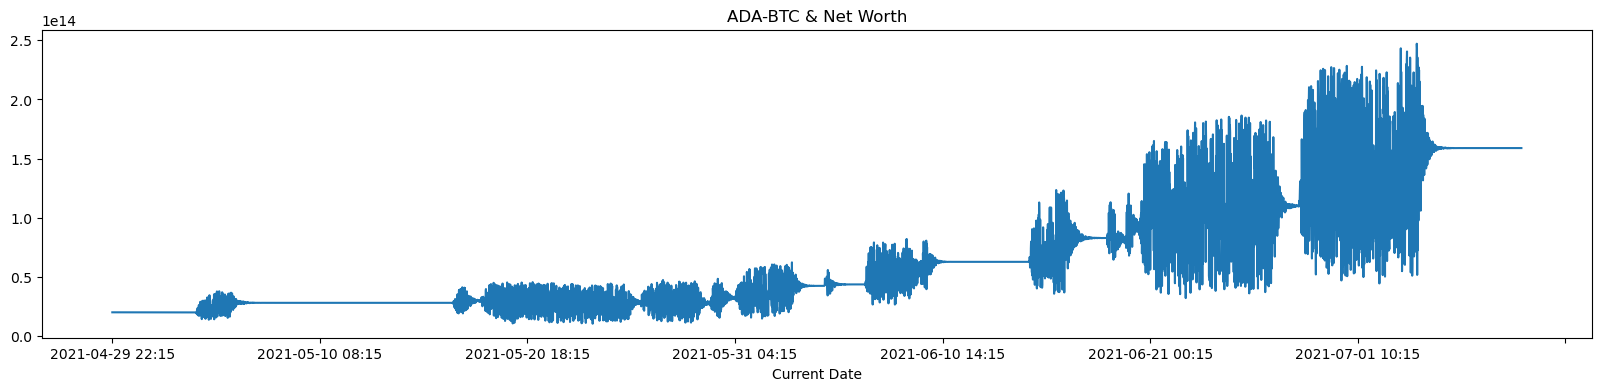

<Figure size 640x480 with 0 Axes>

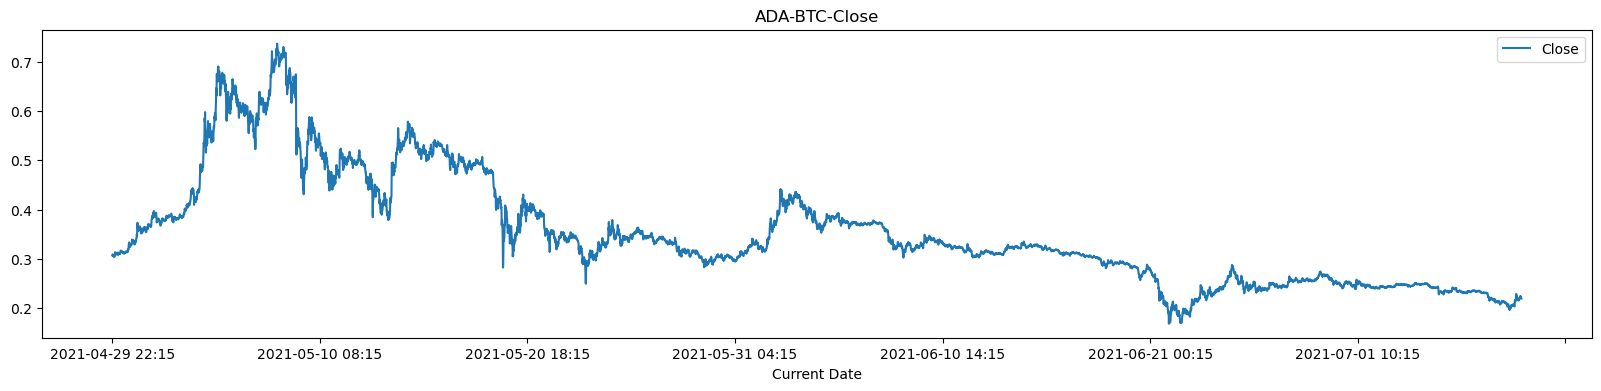

In [80]:
results_df['Net Worth'].plot(figsize = (20, 4), title = f"ADA-BTC & Net Worth")
plt.figure()
results_df[['Close']].plot(figsize = (20, 4), title = "ADA-BTC-Close")
print(results_df.index.is_unique)

<AxesSubplot:>

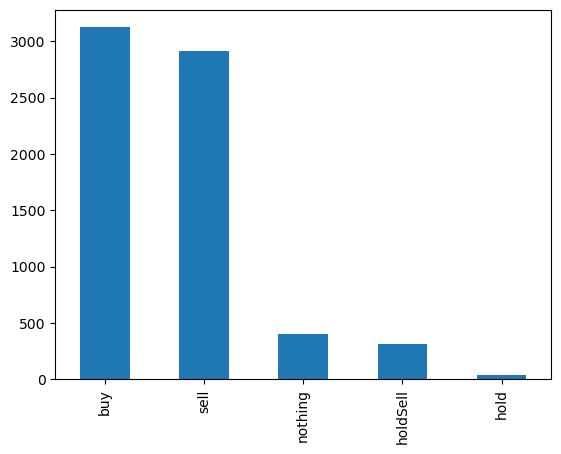

In [81]:
results_df['Type'].value_counts().plot.bar()

In [74]:
results_df['Type'].value_counts()[['holdSell','holdBuy']].sum() / results_df['Type'].value_counts().sum()

0.9404919723081455

In [82]:
results_df['Net Worth'].max() / results_df['Net Worth'][0]

12.35465464477745

In [83]:
results_df['Net Worth'][-1] / results_df['Net Worth'][0], results_df['Close'][-1] / results_df['Close'][0]

(7.943450677473444, 0.715076522305438)

In [77]:
results_df['Net Worth'][-1]

192.1286

In [78]:
results_df['Close'][0], results_df['Close'][-1]

(0.3071, 0.2196)

In [122]:
results_df.index[0], results_df.index[-1], 

(Timestamp('2021-04-29 22:15:00'), Timestamp('2021-06-22 07:15:00'))

In [120]:
np.unique(results_df.index).shape, results_df.index.shape

((6593,), (6593,))

<AxesSubplot:xlabel='Current Date'>

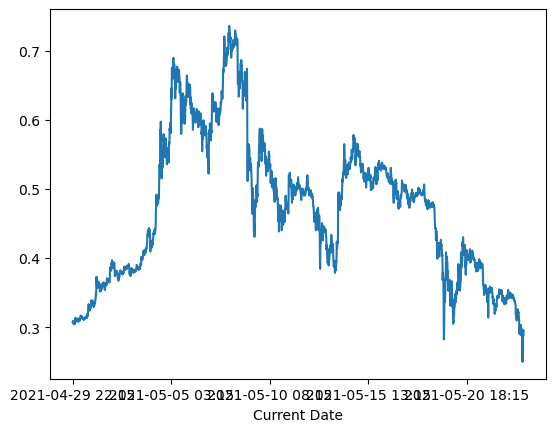

In [63]:
results_df['Close'].plot()

In [97]:
results_df.Type.value_counts()

sell    1357
buy      916
Name: Type, dtype: int64

<AxesSubplot:xlabel='Date'>

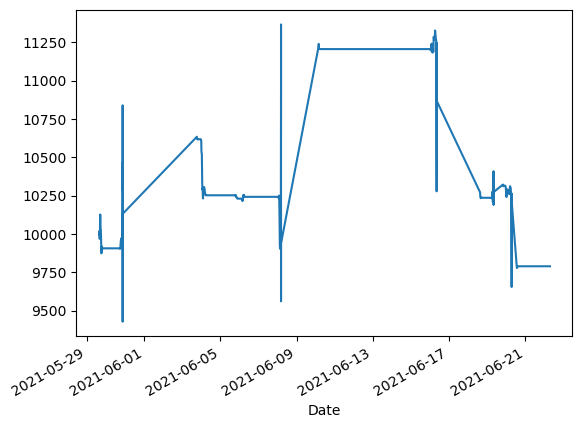

In [89]:
results_df['Net Worth'].plot()

<AxesSubplot:xlabel='Date'>

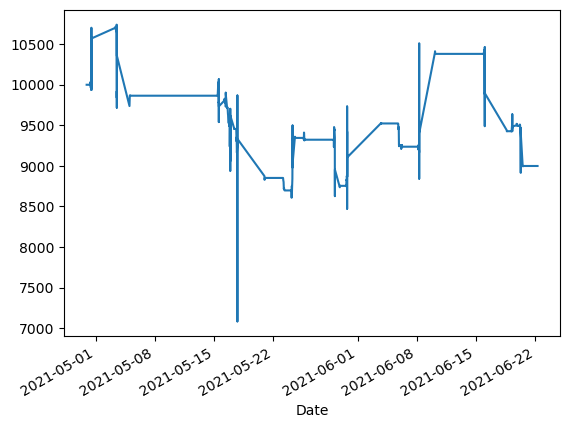

In [73]:
results_df['Net Worth'].plot()

In [23]:
train_env.venv.envs[0].get_info()

{'Date': '2019-09-15 06:45',
 'High': 10318.68,
 'Low': 10296.68,
 'total': 0.273276832541101,
 'type': 'buy',
 'current_price': 10306.941209740045,
 'adj_price': 1.0008134658205596,
 'Open': 10305.86,
 'Close': 10315.57,
 'balance': 6569.88799588778,
 'net_worth': 9538.110490695122,
 'crypto_bought': 0.273276832541101,
 'crypto_sold': 0,
 'crypto_held': 0.28798286847725263,
 'profit': -461.8895093048777,
 'profit_percent(%)': -4.618895093048777,
 'features': ['Open',
  'High',
  'Low',
  'Close',
  'Volume',
  'psar',
  'MACD',
  'RSI',
  'ema7',
  'ema25',
  'ema99',
  'log_return',
  'super_trend',
  'super_trend_s',
  'super_trend_l'],
 'Initial Balance': 10000,
 'Lookback_size': 154,
 'Reward strategy': 'PnL'}

In [24]:
test_env = DummyVecEnv(
            [lambda: DiscreteStockEnvironment(df = test_df, lookback_window_size=lookback_window_size, 
                                              indicator_list = indicator_list, reward_strategy= 'PnL', adjust_price=True,
                                              normalize_obs=True, sequential=True)]
    
)
    
# Automatically normalize the input features and reward
test_env = VecNormalize(test_env, training = False)

print('model_path', model_path)
model = PPO('MlpPolicy', test_env)
model = model.load(model_path)

model_path pretrained/PPO_discrete_lr0.0001__step3000000_2021-06-16 13:08


In [25]:
test_env = DummyVecEnv(
            [lambda: DiscreteStockEnvironment(df = test_df, lookback_window_size=lookback_window_size, 
                                              indicator_list = indicator_list, reward_strategy= 'PnL', adjust_price=True,
                                              normalize_obs=True, sequential=True)]
    
)
    
# Automatically normalize the input features and reward
test_env = VecNormalize(test_env, training = False)

print('model_path', model_path)
model = PPO('MlpPolicy', test_env)
model = model.load(model_path)


done = False
n_iter = 500
num_episode = 1
results = []

env = test_env

for episode in range(num_episode):
    state = env.reset()
    
    t = 0
    while not done:
        env.render()
        action = env.action_space.sample()
        action, _ = model.predict(state, deterministic=True)
        #action = buy_once_then_hold(t)
        next_state, reward, done, info = env.step(action)
        results.append(pd.DataFrame(info, index=[t]))
        state = next_state
        t+=1
        
results_df = pd.concat(results)
results_df = post_process_results(results_df, save_excel=True, model_name="D-PPO Only OHCLV")

In [26]:
results_df.Type.value_counts()

sell    616
hold    467
buy     316
Name: Type, dtype: int64

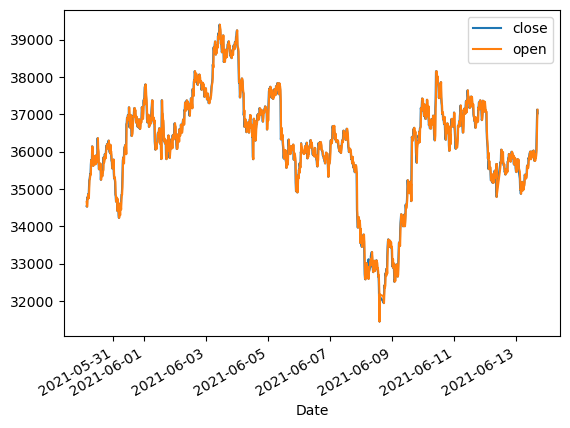

In [27]:
results_df['Close'].plot(label = 'close')
results_df['Open'].plot(label = 'open')
plt.legend()
plt.show()

plt.figure()
results_df['Net Worth'].plot(label = 'Net Worth')
plt.legend()
plt.show()

In [146]:
training_batch_size = 500
train_episodes = 10
visualize = False


df = pd.read_csv('./data/BTCUSDT-1m-data_historical.csv')
df = preprocess_df(df)


lookback_window_size = 200 # 6 hours
test_window = 120 # Since 2021
train_df, test_df = time_split(df, lookback_window_size, test_window)

env = DiscreteStockEnvironment(df = train_df, lookback_window_size = lookback_window_size, 
                               normalize_obs=True, initial_balance = 10000, sequential= False,
                               render_range = 300, reward_strategy='benchmark',
                               name = "Custom Trading Environment v1")

all_episode_rewards = []
    
for episode in range(train_episodes):
    state = env.reset()
    episode_rewards = []
    for t in range(training_batch_size):
        env.render(visualize)
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        state = next_state
        
        if done:
            state = env.reset()
            
        episode_rewards.append(reward)

    all_episode_rewards.append(sum(episode_rewards))

mean_episode_reward = np.mean(all_episode_rewards)
print("Mean reward:", mean_episode_reward, "Num episodes:", train_episodes)

Adding indicators...
Data is fetched from path!
Mean reward: -343160.5655305729 Num episodes: 10


In [268]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import A2C, PPO, SAC, DDPG, TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


df = pd.read_csv('./data/BTCUSDT-1m-data_historical.csv')
df = preprocess_df(df)


lookback_window_size = 200 # 6 hours
test_window = 120 # Since 2021
train_df, test_df = time_split(df, lookback_window_size, test_window)



train_env = DummyVecEnv(
            [lambda: DiscreteStockEnvironment(df = train_df, lookback_window_size = lookback_window_size, 
                                               normalize_obs=True, initial_balance = 10000, sequential= False,
                                               render_range = 300, reward_strategy='benchmark',
                                               name = "Custom Trading Environment v1")]
    
)
    
# Automatically normalize the input features and reward
train_env = VecNormalize(train_env, norm_obs=True,
                         norm_reward=True, clip_obs=10)

learning_rate = 1e-5
clip_range = 0.2
total_timesteps = 5000000

model = PPO('MlpPolicy', train_env, verbose=1,
            tensorboard_log="./runs/",
            learning_rate = learning_rate, clip_range = clip_range)



model.learn(total_timesteps = total_timesteps)

model.save(f'pretrained/{model.__class__.__name__}_discrete_lr{1e-5}_clip{clip_range}_step{total_timesteps}_{datetime.now().strftime("%Y-%m-%d %H:%M")}')

Adding indicators...
Data is fetched from path!
Using cuda device
Logging to ./runs/PPO_11
-----------------------------
| time/              |      |
|    fps             | 272  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 239          |
|    iterations           | 2            |
|    time_elapsed         | 17           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 2.224464e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.4         |
|    explained_variance   | 0.0486       |
|    learning_rate        | 1e-05        |
|    loss                 | 0.0704       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00132     |
|    value_

In [225]:
from torch.optim import Adam
from stable_baselines3.common.callbacks import EvalCallback

df = pd.read_csv('./data/BTCUSDT-1m-data_historical.csv')
df = preprocess_df(df)


lookback_window_size = 200 # 6 hours
test_window = 1200 # Since 2021
train_df, test_df = time_split(df, lookback_window_size, test_window)



train_env = DummyVecEnv(
            [lambda: DiscreteStockEnvironment(df = train_df, lookback_window_size = lookback_window_size, 
                                               normalize_obs=True, initial_balance = 10000, sequential= False,
                                               render_range = 300, reward_strategy='benchmark',
                                               name = "Custom Trading Environment v1")]
    
)

# Automatically normalize the input features and reward
train_env = VecNormalize(train_env, norm_obs=True,
                         norm_reward=True, clip_obs=10)


eval_env = DummyVecEnv(
            [lambda: DiscreteStockEnvironment(df = test_df, lookback_window_size = lookback_window_size, 
                                               normalize_obs=True, initial_balance = 10000, sequential= True,
                                               render_range = 300, reward_strategy='benchmark',
                                               name = "Custom Trading Environment v1")]
    
)




# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env, best_model_save_path='./pretrained/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)


learning_rate = 1e-5
model = A2C('MlpPolicy', train_env, verbose=1,
            tensorboard_log="./runs/", learning_rate = learning_rate, 
            normalize_advantage = True,)

model.policy_kwargs['optimizer_class'] = Adam
model.policy_kwargs['optimizer_kwargs'] = {'eps': 1e-05, 'weight_decay': 0}

model.learn(total_timesteps = 500000)


model_name = f"A2C_lr{learning_rate}_optimAdam"
model.save(f'pretrained/{model_name}')


Adding indicators...
Data is fetched from path!
Using cuda device
Logging to ./runs/A2C_5
------------------------------------
| time/                 |          |
|    fps                | 189      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -3.4     |
|    explained_variance | -0.524   |
|    learning_rate      | 1e-05    |
|    n_updates          | 99       |
|    policy_loss        | 0.00028  |
|    value_loss         | 0.00469  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 193       |
|    iterations         | 200       |
|    time_elapsed       | 5         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -3.4      |
|    explained_variance | -1.46     |
|    learning_rate      | 1e-05     |
|    n_updat

In [4]:
ls pretrained/

' 2021-05-09 15: 17_trader'/
'2021-05-04 14: 19_trader'/
'2021-05-06 18: 01_trader'/
'2021-05-08 14: 32_trader'/
'2021-05-24 09: 36_trader'/
'2021-05-24 12: 22_trader'/
'2021-05-25 13: 31_agent_PPO'/
 2021_01_18_22_18_Crypto_trader/
 A2C_continious.zip
 A2C_lr1e-05_optimAdam.zip
 PPO_0.6_ev
 PPO_incele.zip
'PPO_lr1e-05_clip0.2_step5000000_2021-06-03 18:59'
